In [1]:
import bambi as bmb
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [31]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_context("poster")
# sns.set_style("whitegrid")
# %config InlineBackend.figure_format='retina'

In [9]:
pm.__version__
%matplotlib inline

In [3]:
RANDOM_SEED = 271827
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
# Create data that has a DAG structure as described in Ben Vincent's blog post at drbenvincent.github.io
# Titled: Causal Inference: have you been doing science wrong all this time?

In [5]:
N = 5_000
Q = rng.normal(size = N)
X = rng.normal(loc = 0.314 * Q, scale = 0.69, size = N)
Y = rng.normal(loc = 0.81 * X + 0.17 * Q, scale = 0.3, size = N)
P = rng.normal(loc = 0.42 * X + 0.63 * Y, scale = 0.2, size = N)
df = pd.DataFrame({"Q": Q, "X": X, "Y": Y, "P": P})
df.head()

,Q,X,Y,P
0,0.023480,0.354332,0.697228,0.092741
1,-0.079138,0.137575,0.163787,-0.044031
2,0.013904,-0.000574,-0.090791,-0.230754
3,0.217560,-0.020444,0.182859,0.111253
4,-0.807178,-0.912287,-0.991703,-0.928748


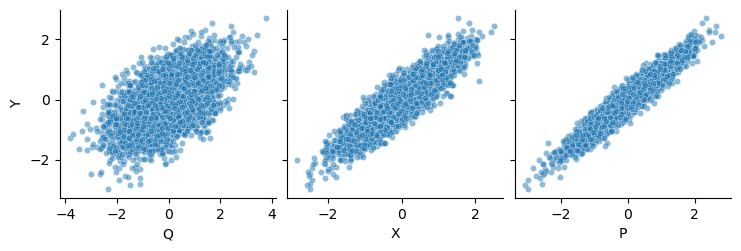

In [6]:
# Which relationship is causal?
plt.close()
sns.pairplot(
    df, 
    x_vars=["Q", "X", "P"], 
    y_vars=["Y"], 
    kind='scatter', 
    diag_kind='kde', 
    plot_kws={'alpha':0.5, 's':20})

plt.show()

# The Linear Regression Approach

In [7]:
model = bmb.Model('Y ~ X', df)
results = model.fit(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Y_sigma, Intercept, X]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


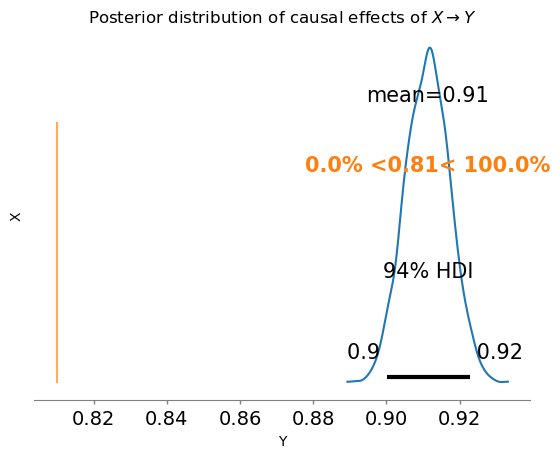

In [13]:
ax = az.plot_posterior(results.posterior["X"], ref_val = 0.81)
ax.set_xlabel("Y")
ax.set_ylabel("X")
ax.set_title(r"Posterior distribution of causal effects of $X \rightarrow Y$");

## The 'Causal Salad' - Multiple Linear Regression Approach
The result is even worse!

In [14]:
model = bmb.Model('Y ~ Q + X + P', df)
results = model.fit(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Y_sigma, Intercept, Q, X, P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


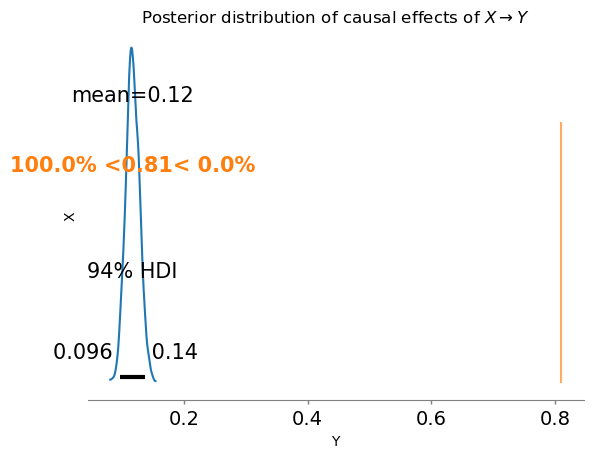

In [15]:
ax = az.plot_posterior(results.posterior["X"], ref_val = 0.81)
ax.set_xlabel("Y")
ax.set_ylabel("X")
ax.set_title(r"Posterior distribution of causal effects of $X \rightarrow Y$");

## The Causal Approach: Linear Regression that blocks the backdoor path 
There is a backdoor between X and Y via Q.  This can be block by including Q in our regression as a control

In [17]:
model = bmb.Model('Y ~ Q + X', df)
results = model.fit(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Y_sigma, Intercept, Q, X]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


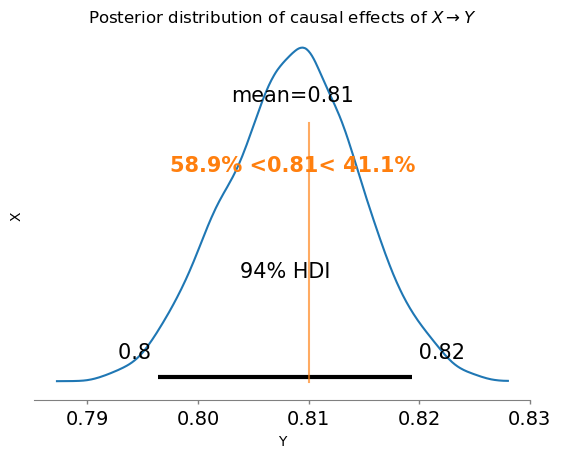

In [18]:
ax = az.plot_posterior(results.posterior["X"], ref_val = 0.81)
ax.set_xlabel("Y")
ax.set_ylabel("X")
ax.set_title(r"Posterior distribution of causal effects of $X \rightarrow Y$");

## Now our parameter estiamte for X is spot on! 
- But that was a lot of work!

## Bayesian Structural Causal Modelling Approach

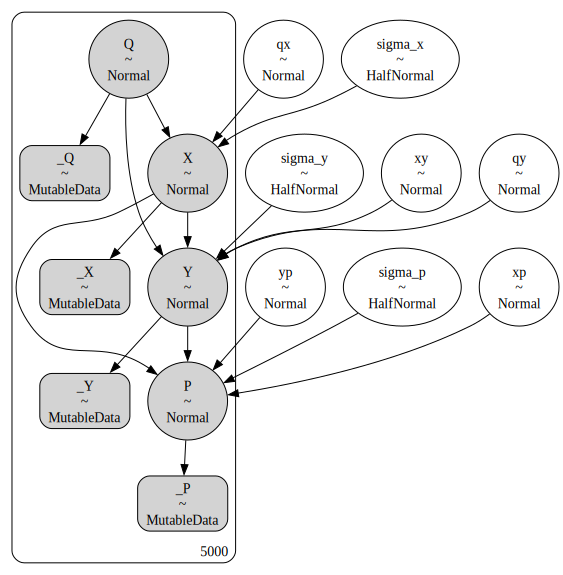

In [20]:
with pm.Model() as model:
    # data
    _Q = pm.MutableData("_Q", df["Q"])
    _X = pm.MutableData("_X", df["X"])
    _Y = pm.MutableData("_Y", df["Y"])
    _P = pm.MutableData("_P", df["P"])
    
    # priors on slopes
    # x ~ q
    qx = pm.Normal("qx")
    # y ~ x + q
    xy = pm.Normal("xy")
    qy = pm.Normal("qy")
    # p ~ x + y
    xp = pm.Normal("xp")
    yp = pm.Normal("yp")
    
    # priors on sd's
    sigma_x = pm.HalfNormal("sigma_x")
    sigma_y = pm.HalfNormal("sigma_y")
    sigma_p = pm.HalfNormal("sigma_p")
    
    # model
    Q = pm.Normal("Q", observed = _Q)
    X = pm.Normal("X", mu = qx * Q, sigma = sigma_x, observed = _X)
    Y = pm.Normal("Y", mu = xy * X + qy * Q, sigma = sigma_y, observed = _Y)
    P = pm.Normal("P", mu = xp * X + yp * Y, sigma = sigma_p, observed = _P)

pm.model_to_graphviz(model)

In [21]:
# Sample from the posterior distribution
with model:
    idata = pm.sample(random_seed = RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [qx, xy, qy, xp, yp, sigma_x, sigma_y, sigma_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


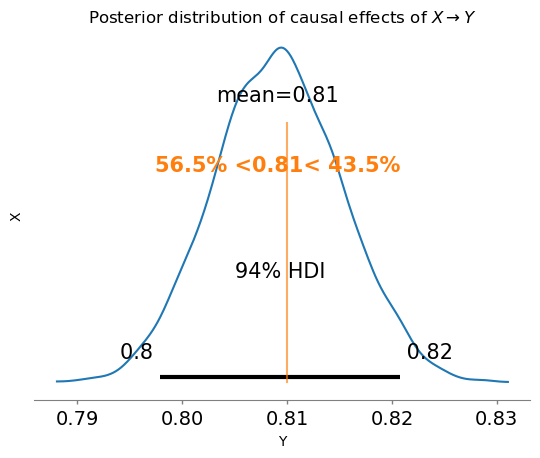

In [22]:
ax = az.plot_posterior(idata, var_names = "xy", ref_val = 0.81)
ax.set_xlabel("Y")
ax.set_ylabel("X")
ax.set_title(r"Posterior distribution of causal effects of $X \rightarrow Y$");